In [ ]:
#11/06/2019

#Attempting to forcast Iron Ore 62% prices (Semi-Personal/Work Project)
#Using an auto ARIMA package similar to what R has

#Sources:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
#https://www.alkaline-ml.com/pmdarima/usecases/stocks.html
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
#https://otexts.com/fpp2/arima-ets.html

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
%matplotlib inline

import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.3.

Using pmdarima 1.3.0


Price Quick Stats ($)

count    130.000000
mean     100.273077
std       39.317220
min       39.600000
25%       66.842500
50%       91.985000
75%      135.310000
max      187.180000
Name: Price, dtype: float64


C:\Users\gcarlstedt\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


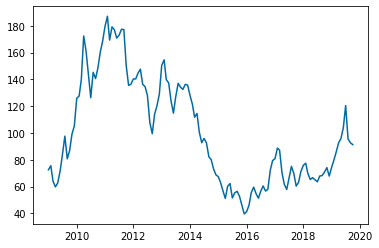

In [4]:
#Skip first 10 rows of excel sheet, asssign Price column float data type, index and datetime date column
df = pd.read_excel(r'C:\Users\gcarlstedt\Documents\Work - Nevada Copper\Iron By Product Possibilities\iron-ore-price-history.xlsx',
                    skiprows=10,dtypes={'Price':float},index_col=0, parse_dates=[0])

data = df['2009':]

print('Price Quick Stats ($)\n')
print(data['Price'].describe())

plt.plot(data)
plt.show()

In [12]:
#Checking Stationarity of a Time Series

#Checking Stationarity
#1. Constant Mean
#2. Constant variance
#3. An autocovariance that does not depend on time

#Perform rolling and DCF tests
#Create function that automatically calculates and visualizes these tests

def test_stationarity(timeseries):
    """Perfrom rolling stats w/plot plus DCF test"""
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller Test
    #Testing if there exists a "Unit Root"-> Stationary or not 
    print('Results from Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Price'],autolag='AIC')

    dfoutput = pd.Series(dftest[0:4],index=['Test Stats','p-value','#Lags Uses','Number of Obersavtions Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)


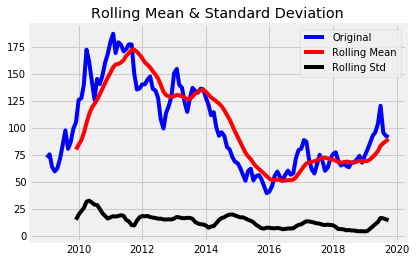

Results from Dickey-Fuller Test:
Test Stats                      -1.717666
p-value                          0.422034
#Lags Uses                      11.000000
Number of Obersavtions Used    118.000000
Critical Values (1%)            -3.487022
Critical Values (5%)            -2.886363
Critical Values (10%)           -2.580009
dtype: float64


In [13]:
test_stationarity(data)

#The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
#root, with the alternative that there is no unit root. If the pvalue is
#above a critical size, then we cannot reject that there is a unit root.

#The p-values are obtained through regression surface approximation from
#MacKinnon 1994, but using the updated 2010 tables. If the p-value is close
#to significant, then the critical values should be used to judge whether
#to reject the null.


#Test stats > critical values
#P-Value = 0.422

#Think we can reject that there is a unit root

#Intuitively we can see that thers isn't a constant mean

In [ ]:
#Another check is an autocorrelation plot that shows the autocorrelations for various lags. 
#Confidence bands can be plotted at the 95 % and 99 % confidence levels. Points outside this 
#band indicate statistically significant values (lag 0 is always 1)

#The critical values at the 5 % significance level are -0.140 and 0.140.
#The critical values at the 10 % significance level are  ~ -0.2 and ~0.2. (?)
#This indicates that the lag 1 autocorrelation is statistically significant, so there is evidence of non-randomness.

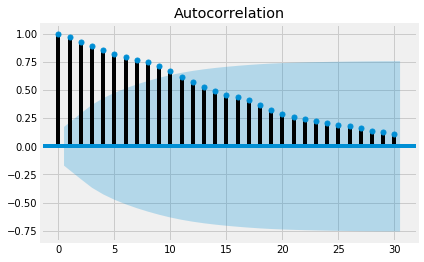

In [95]:
#Autocorrelaation plot from pm.ARIMA model to further test if the time series is 
#sufficiently stationary for modeling

pm.plot_acf(data,lags=30,alpha=0.05)

#If a spike is significantly different from zero, that is evidence of autocorrelation. 
#A spike that’s close to zero is evidence against autocorrelation

#In this example, spikes are statistically significant for lags up to ~25. 
#This means that the Iron stock prices are highly correlated with each other. 
#In other words, when the price of Iron rises, it tends to continue rising. 
#When the price of Iron falls, it tends to continue falling

In [ ]:
#Estimating the differencing term

#Pre-modeling analysis
#Could perform transformation/differencing beforehand, but could be painstakingly time consuming 
#If you don't have domain knowledge

#Typical common transformation for enforcing stationarity

#Square root or N-th root transformations
#De-trending your time series
#Differencing your time series one or more times
#Log transformations

#Note: Transformation on data as a pre-processing stage will result in forecasts in the transformed space as well

In [128]:
#We'll use KPSS and ADF tests, selecting the highest max value between the two to be conservative
#Using full data set

kpss_diffs = ndiffs(data['Price'], alpha=0.05, test='kpss',max_d=6) 
adf_diffs = ndiffs(data['Price'], alpha=0.05, test='adf',max_d=6)
n_diffs = max(adf_diffs,kpss_diffs)

print(f'Estimated differencing term: {n_diffs}')

Estimated differencing term: 1


Fit ARIMA: order=(2, 1, 2); AIC=950.295, BIC=967.454, Fit time=0.305 seconds
Fit ARIMA: order=(0, 1, 0); AIC=951.106, BIC=956.826, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=948.422, BIC=957.001, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 1); AIC=946.584, BIC=955.163, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 1); AIC=946.755, BIC=958.194, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 2); AIC=946.437, BIC=957.876, Fit time=0.073 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 3); AIC=948.437, BIC=962.736, Fit time=0.112 seconds
Total fit time: 0.737 seconds
(0, 1, 2)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1505      0.893      0.168      0.866      -1.600       1.901
ma.L1.D.y      0.2331      0.088      2.655      0

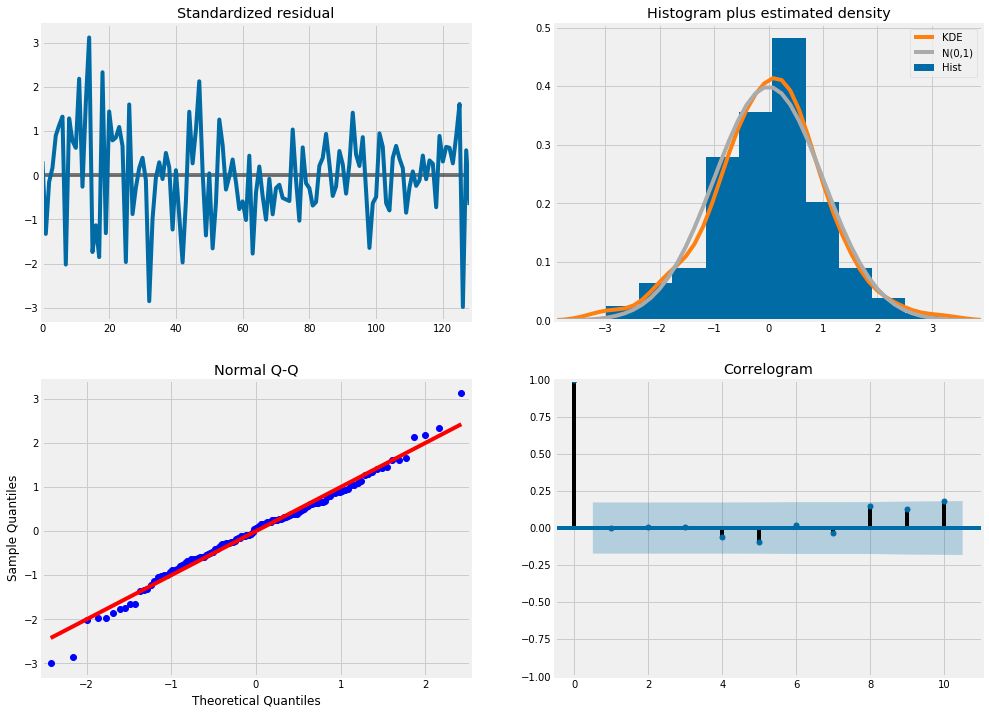

In [323]:
#Fitting Model
#Let's test this autoARIMA model

#Use a “grid search” to iteratively explore different combinations of parameters for the ARIMA Model
#Hyperparameter optimization for model selection

auto = pm.auto_arima(data['Price'], d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

results = auto.fit(data['Price'])
print(auto.order)
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

#ARIMA model in words:
#Predicted Yt = 
#Constant + 
#Linear combination Lags of Y (upto p lags) + 
#Linear Combination of Lagged forecast errors (up to q lags)

In [ ]:
#The summary attribute that results from the output of ARIMA returns a significant amount of information, 
#but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) 
#of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each 
#feature weight. Optimally want P values to be around 0.05 for all coef, excluding constant(?) 
#2nd moving average values is a little high, but should be okay 

In [ ]:
#Evalulate results and modeling from auto ARIMA

#Important to run model diagnostics to ensure that none of the assumptions made by the model have been violated

#Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed 
#with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that 
#it can be further improved

#In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

#In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the 
#standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication 
#that the residuals are normally distributed.

#The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the 
#linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a 
#strong indication that the residuals are normally distributed.

#The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. 
#This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the 
#time series residuals have low correlation with lagged versions of itself


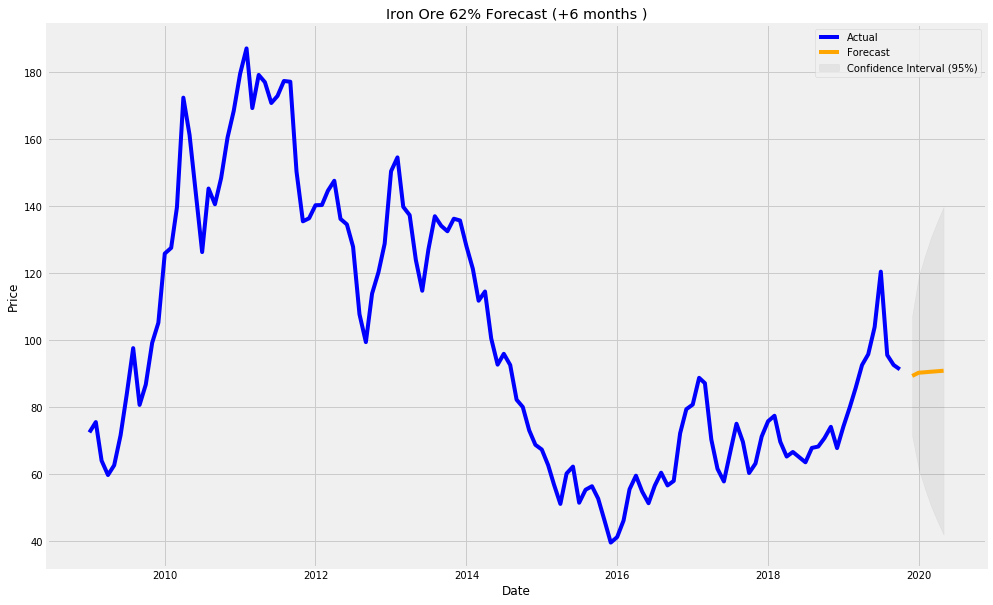

In [331]:
#Forecast Model

model = auto 
n_periods = 6 #Next x months forecast

fc, conf_int = model.predict(n_periods=n_periods,return_conf_int=True,alpha=0.05)
index = pd.date_range('2019-11-01',periods=n_periods,freq='M')

#Create series for plotting
fc_series = pd.Series(fc, index=index)
lower_series = pd.Series(conf_int[:, 0], index=index)
upper_series = pd.Series(conf_int[:, 1], index=index)

# Plot
plt.figure(figsize=(15,10))
plt.plot(data,color='blue',label='Actual')
plt.plot(fc_series, color='orange', label='Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=0.05, label='Confidence Interval (95%)')

plt.title("Iron Ore 62% Forecast (+{} months )".format(n_periods))
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()


In [ ]:
#---------------------------------------------------------------------------------------------------------------------#
#Machine learning model

#Data Splitting for ML modeling

#Split data to evaluate model performance on a hold-out set

#However, since time series models intrinsically introduce endogenous temporality
#Must have a clean split since the value at y(t) has some affect on y(t+n) 
#--> Previous values have some influence on future values

#Take in to account exogenous variables, if present as well
#An exogenous variable is a variable that is not affected by other variables in the system
#n an economic model, an exogenous variable is one whose value is determined outside the model 
#and is imposed on the model

#Use 80/20 split

In [197]:
train_len = int(data.shape[0]*0.8)
train_data, test_data = data[:train_len], data[train_len:] #Spltting data into train and test data

y_train = train_data['Price'].values #List for train data
y_test = test_data['Price'].values  #list for test data

print(f"{train_len} train samples")
print(f"{data.shape[0] - train_len} test samples")

#Maybe not enough Data? 

104 train samples
26 test samples


In [206]:
#We'll use KPSS and ADF tests, selecting the highest max value between the two to be conservative

kpss_diffsml = ndiffs(y_train, alpha=0.05, test='kpss',max_d=6) 
adf_diffsml = ndiffs(y_train, alpha=0.05, test='adf',max_d=6)
n_diffsml = max(adf_diffsml,kpss_diffsml)

print(f'Estimated differencing term: {n_diffsml}')

Estimated differencing term: 1


Fit ARIMA: order=(2, 1, 2); AIC=768.290, BIC=784.099, Fit time=0.109 seconds
Fit ARIMA: order=(0, 1, 0); AIC=769.128, BIC=774.397, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=765.932, BIC=773.836, Fit time=0.018 seconds
Fit ARIMA: order=(0, 1, 1); AIC=763.872, BIC=771.776, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 1); AIC=764.581, BIC=775.120, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 2); AIC=764.406, BIC=774.945, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.212 seconds
(0, 1, 1)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0610      1.234      0.049      0.961      -2.358       2.480
ma.L1.D.y      0.3105      0.109      2.859      0.005       0.098       0.523


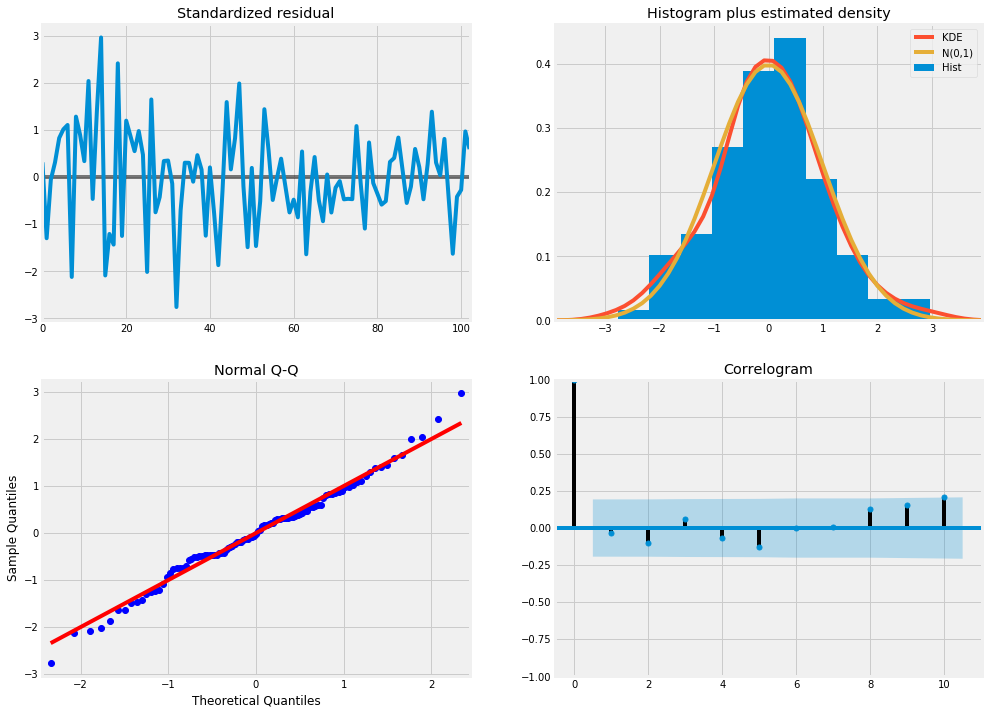

In [297]:
#Fitting Model
#Let's test this autoARIMA model

#Use a “grid search” to iteratively explore different combinations of parameters for the ARIMA Model
#Hyperparameter optimization for model selection

automl = pm.auto_arima(y_train, d=n_diffsml, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

resultsml = automl.fit(y_train)
print(automl.order)
print(resultsml.summary().tables[1])

resultsml.plot_diagnostics(figsize=(15, 12))
plt.show()

#ARIMA model in words:
#Predicted Yt = 
#Constant + 
#Linear combination Lags of Y (upto p lags) + 
#Linear Combination of Lagged forecast errors (up to q lags)

In [284]:
#Update model by simulating days passing with test set

#For each new observation, let the model progress for several more iterations
#allowing MLE to update its discoverd parameters and shifting the observed value

modelml = automl #seeded from previous train data set already fit

def forecast_one_step():
    fc, conf_int = modelml.predict(n_periods=1,return_conf_int=True)
    return(
        fc.tolist()[0],
        np.array(conf_int).tolist()[0])

forecastml = []
confindence_intervalml = []

for new_obml in y_test:
    fcml, confml = forecast_one_step()
    forecastml.append(fcml)
    confindence_intervalml.append(confml)

# Updates the existing model with a small number of MLE steps
modelml.update(new_obml)


print(f"Mean squared error: {mean_squared_error(y_test, forecast)}")
print(f"MAPE: {np.mean(np.abs(forecast - y_test)/np.abs(y_test))}")
print(f"SMAPE: {smape(y_test, forecast)}")

Mean squared error: 214.40365280615435
MAPE: 0.14348777873646015
SMAPE: 14.559824928200104


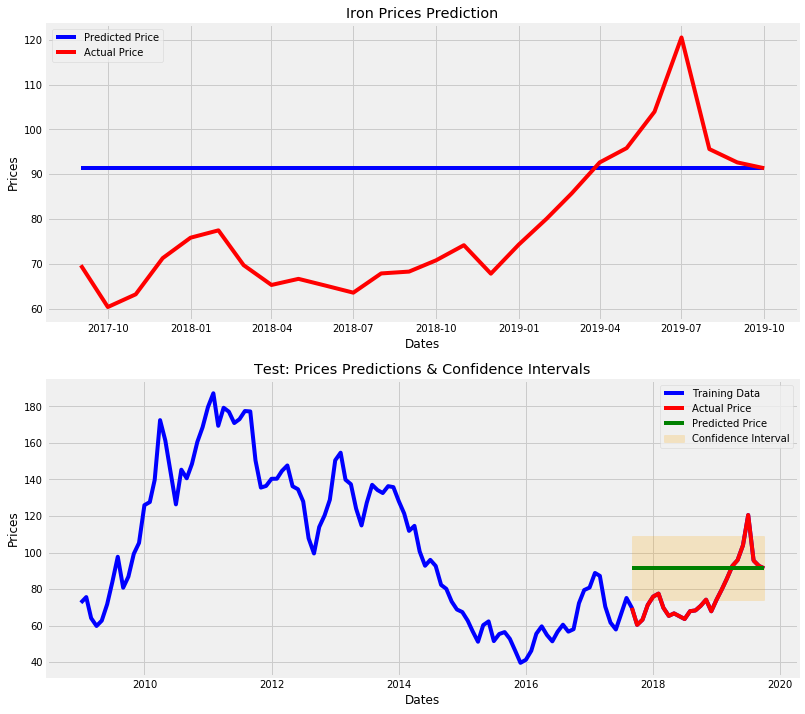

In [285]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(test_data.index, forecastml, color='blue',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Iron Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].legend()

# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(data, color='blue', label='Training Data')
axes[1].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[1].plot(test_data.index, forecastml, color='green',
             label='Predicted Price')

axes[1].set_title('Test: Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confindence_intervalml)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.2, color='orange',
                     label="Confidence Interval")
axes[1].legend()

In [294]:
#ARIMA (0,1,1)

#Random Walk with an MA(1) term on top

#The forecast for a random walk is its last observed value, regardless of forecast horizon
#The forecast for an MA(1) process is nonzero only for horizon h=1. 
#Thus you get a constant forecast (equal to the last observed value plus one value of MA(1) term) beyond h=1. 
#This is what you see in the graph. Nothing wrong with it.

#If you expect the upward-sloping linear time trend to continue, you could consider using a random walk model 
#with positive drift. That would give you something more consistent with the historical trend.

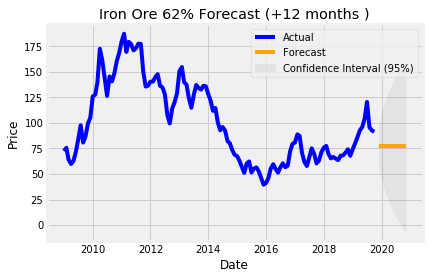

In [299]:
#Forecast Model --> ML Model

modelml = automl
n_periods = 12 #Next 12 months forecast

fcml, conf_intml = modelml.predict(n_periods=n_periods,return_conf_int=True,alpha=0.05)
indexml = pd.date_range('2019-11-01',periods=n_periods,freq='M')

#Create series for plotting
fc_seriesml = pd.Series(fc, index=index)
lower_seriesml = pd.Series(conf_intml[:, 0], index=index)
upper_seriesml = pd.Series(conf_intml[:, 1], index=index)

# Plot
plt.plot(data,color='blue',label='Actual')
plt.plot(fc_seriesml, color='orange', label='Forecast')
plt.fill_between(lower_seriesml.index, 
                 lower_seriesml, 
                 upper_seriesml, 
                 color='k', alpha=.05, label='Confidence Interval (95%)')

plt.title("Iron Ore 62% Forecast (+{} months )".format(n_periods))
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()
